In [1]:
%%capture
import re # to handle regular expression
import demoji  # for emojis handle
import random # to generate random number
import inflect  # to handle number to words
import numpy as np # scitific calculation 
import pandas as pd # data manipulation 
from bs4 import BeautifulSoup # handle html tag
import matplotlib.pyplot as plt # plot any display

import torch # deep learning handle
import torchtext # nlp handle
import torch.nn as nn # NN handle
import torch.optim as optim # optimizer handle
import torch.nn.functional as F # all type to DL funciton
from torch.nn.functional import one_hot # encoder-decoder
from torchtext.data.utils import get_tokenizer # tokenize 
print('Successfully import all the libraries')

In [2]:
# Reading the text 
file_path = 'human_chat.txt'
with open(file_path,"r") as f:
    lines = f.readlines()

In [3]:
type(lines[1])

str

In [4]:
soup = BeautifulSoup(str(lines), 'html.parser')
text = soup.get_text()

In [5]:
def preprocess_text(text):
        # Remove HTML tags
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()

        p = inflect.engine() #101
        # demoji.download_codes()
        # Remove emojis
        text = demoji.replace(text, "")

        # Remove mentions of "Human 1" and "Human 2"
        text = re.sub(r'\b(?:Human 1|Human 2)\b:?', " ", text)

        # Replace numbers with words
        text = re.sub(r'\b\d+\b', lambda x: p.number_to_words(x.group()), text)

        # Remove special characters, keeping only alphabetic and spaces
        text = re.sub('[^a-zA-Z\s]', ' ', text)

        # Replace specific unicode spaces with standard spaces and trim
        text = text.replace(u'\xa0', u' ').replace('\u200a', ' ').strip()

        return text

In [6]:
preprocessed_lines = [preprocess_text(line) for line in lines]

/tmp/ipykernel_6081/3061531194.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [7]:
preprocessed_lines[0:5]

['Hi',
 'What is your favorite holiday',
 'one where I get to meet lots of different people',
 'What was the most number of people you have ever met during a holiday',
 'Hard to keep a count  Maybe twenty five']

In [8]:
# Tokenize the words
tokenizer = get_tokenizer('basic_english')
tokenized_conv = [tokenizer(conv) for conv in preprocessed_lines]

In [9]:
tokenized_conv[2]

['one', 'where', 'i', 'get', 'to', 'meet', 'lots', 'of', 'different', 'people']

In [10]:
tokenized_conv[3]

['what',
 'was',
 'the',
 'most',
 'number',
 'of',
 'people',
 'you',
 'have',
 'ever',
 'met',
 'during',
 'a',
 'holiday']

In [11]:
tokenized_conv[1]

['what', 'is', 'your', 'favorite', 'holiday']

## ```build_vocab_from_iterator```

```build_vocab_from_iterator``` function in the ```torchtext.vocab``` modeule is used to create vocabulary from an iterable of tokenized data. This vocabulary is essential for converting textual data into numerical form.

## Parameters:

### ```tokenized_conv(iterator)```:
This is the main data input to the function. It should be an iterator(like a ```generator``` or a ```list```) that yields sequences to tokens. Each sequences represents a document or an example in your dataset.

### ```min_freq(int,optional):```
This parameter specifics the mimimum frequency a token must have to be inclued in the vocabulary. Tokens that appear fewer than ```min_freq``` times are excluded form the vocabulary. This is useful for removing rare words which might be typos or irrelevant to most analysis.

### ```specials(list of str, optional)```:
This is a list of special tokens that you want to add to the vocabulary. Common special tokens include: A padding token used to equalize the lenghts of sequence.(or for unknown): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not int the traning vocabualry. 

### ```special_first(bool, optional)```:
Determine the ordering of special tokens in the vocabulary. If ```True```, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant(e.g., models using embadding layers might have specific handling for lower indices.)

In [12]:
features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1,
    specials=['<pad>', '<oov>'],
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_conv,
    min_freq=1
)

In [13]:
features_vocab_total_words = len(features_vocab)
target_vocab_toal_words = len(target_vocab)
print("Features Vocab Length:", features_vocab_total_words)
print("Features Vocab Length:", target_vocab_toal_words)

Features Vocab Length: 2749
Features Vocab Length: 2747


In [14]:
# making ngrams from the conversations
def make_ngrams(tokenized_text):
    list_ngrams = []
    for i in range(1, len(tokenized_text)):
        ngram_sequence = tokenized_text[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

In [15]:
ngrams_list = []
for tokenized_con in tokenized_conv:
    ngrams_list.extend(make_ngrams(tokenized_con))

In [16]:
ngrams_list[1:10]

[['what', 'is', 'your'],
 ['what', 'is', 'your', 'favorite'],
 ['what', 'is', 'your', 'favorite', 'holiday'],
 ['one', 'where'],
 ['one', 'where', 'i'],
 ['one', 'where', 'i', 'get'],
 ['one', 'where', 'i', 'get', 'to'],
 ['one', 'where', 'i', 'get', 'to', 'meet'],
 ['one', 'where', 'i', 'get', 'to', 'meet', 'lots']]

In [17]:
# add random oov takens to let the model handle oov tokens 
def add_random_oov_tokens(ngram_oov):
    for idx, word in enumerate(ngram_oov[:-1]):
        if random.uniform(0,1) < 0.1:
            ngram_oov[idx] = '<oov>'
    return ngram_oov

In [18]:
ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_tokens(ngram_oov=ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))

True


In [19]:
ngrams_list_oov[1:10]

[['what', '<oov>', 'your'],
 ['what', 'is', 'your', 'favorite'],
 ['<oov>', 'is', '<oov>', 'favorite', 'holiday'],
 ['one', 'where'],
 ['one', 'where', 'i'],
 ['one', 'where', 'i', 'get'],
 ['one', 'where', 'i', 'get', 'to'],
 ['one', 'where', 'i', '<oov>', 'to', 'meet'],
 ['one', 'where', 'i', 'get', 'to', 'meet', 'lots']]

#### Text to numeric form

In [20]:
def text_to_numerical_sequence(tokenized_text):
    tokens_list = []
    if tokenized_text[-1] in target_vocab.get_itos():
        for token in tokenized_text[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

In [21]:
input_sequence = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]

In [22]:
print(f"Total input sequence: {len(input_sequence)}")
print(input_sequence[3:5])

Total input sequence: 18562
[[1, 13, 1, 120, 312], [56, 88]]


In [23]:
X = [sequence[:-1] for sequence in input_sequence]
y = [sequence[-1] for sequence in input_sequence]
len(X[0]), y[0]

(1, 11)

In [24]:
print(X[3], y[3])

[1, 13, 1, 120] 312


In [25]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

153

The tensor to be padded.

In [26]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence),0), value=0) for sequence in X]
padded_X[1], X[2], len(padded_X[1])

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 12,  1]),
 [12, 13, 29],
 153)

In [27]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)

(torch.Tensor, torch.Tensor)

In [28]:
y_one_hot = one_hot(y, num_classes=target_vocab_toal_words)

In [29]:
from torch.utils.data import TensorDataset
data = TensorDataset(padded_X, y_one_hot)

In [30]:
data[1:1]

(tensor([], size=(0, 153), dtype=torch.int64),
 tensor([], size=(0, 2747), dtype=torch.int64))

In [31]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32

In [33]:
from torch.utils.data import random_split
train_data, test_data = random_split(data, [train_size, test_size])

In [34]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [41]:
import torch.nn as nn
class My_BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_toal_words, embedding_dim, hidden_dim):
        super(My_BiLSTM, self).__init__()
        self.embadding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_toal_words)
    


    def forward(self, x):
        x = x.to(self.embadding.weight.device)
        embadded = self.embadding(x)
        lstm_out, _ = self.lstm(embadded)
        lstm_out = self.dropout(lstm_out)
        # since the LSTM is bidirectional, we calculate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For the batch_first = True, the last timestamp of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestamp of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:,-1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [39]:
features_vocab_total_words = 2749
target_vocab_toal_words = 2749
embadding_dim = 128
hidden_dim = 200
epochs = 50

In [42]:
model = My_BiLSTM(features_vocab_total_words, target_vocab_toal_words, embedding_dim=embadding_dim, hidden_dim=hidden_dim)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0009)

# define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [45]:
model.to(device=device)

My_BiLSTM(
  (embadding): Embedding(2749, 128)
  (lstm): LSTM(128, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=2749, bias=True)
)

In [48]:
def calculate_topk_accuracey(model, data_loader, k=3):
    model.eval()
    correct_prediction = 0
    total_prediction = 0

    with torch.no_grad():
        for batch_x, batch_y, in data_loader:
            batch_x, batch_y = batch_x.to(device),batch_y.to(device)

            # forward pass
            output = model(batch_x)

            # Get top-K prediction
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k prediction
            correct_prediction += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_prediction += batch_y.size(0)
        accuracy = correct_prediction / total_prediction
        return accuracy    

In [49]:
all_accuracies = []
all_losses = []

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device),batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)

        # loss
        loss = criterion(output, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracey(model, train_loader)
        print(f'Epoch {epoch}/{epochs} | Loss: {loss.item():.4f} | Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())

Epoch 0/50 | Loss: 2.9431 | Train K-Accuracy: 24.84%
Epoch 5/50 | Loss: 4.9344 | Train K-Accuracy: 56.19%
Epoch 10/50 | Loss: 2.6106 | Train K-Accuracy: 83.65%
Epoch 15/50 | Loss: 4.6400 | Train K-Accuracy: 92.16%
Epoch 20/50 | Loss: 0.9576 | Train K-Accuracy: 94.60%
Epoch 25/50 | Loss: 1.2850 | Train K-Accuracy: 95.43%
Epoch 30/50 | Loss: 0.2250 | Train K-Accuracy: 95.70%
Epoch 35/50 | Loss: 1.0486 | Train K-Accuracy: 95.82%
Epoch 40/50 | Loss: 0.1404 | Train K-Accuracy: 95.91%
Epoch 45/50 | Loss: 0.6597 | Train K-Accuracy: 95.98%


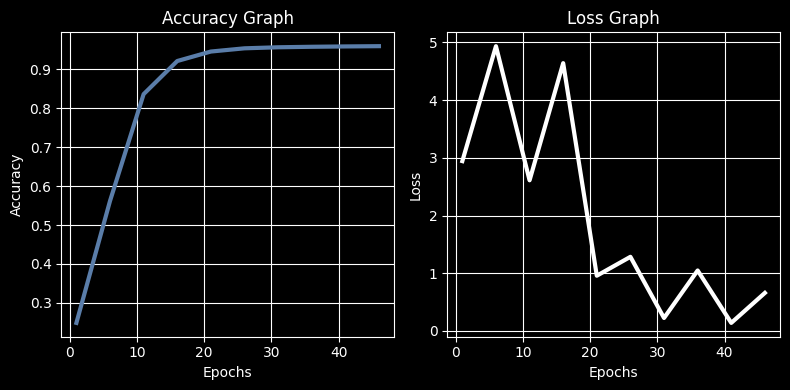

In [57]:
epoch_x = [i for i in range(1, epochs, 5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(epoch_x, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)

axes[1].plot(epoch_x, all_losses, color='#FFFFFF', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [81]:
accuracy = calculate_topk_accuracey(model=model, data_loader=test_loader)
print(f"Test K-Accuracy: {accuracy * 100:.2f}")

Test K-Accuracy: 20.93


In [89]:
import os
model_path = 'my_bilstm_model.pth'
torch.save(model.state_dict(), model_path)
print(f'{model_path}')

my_bilstm_model.pth


In [94]:
model_path = 'my_bilstm_model.pth'
torch.save(model, model_path)
print(f'Model saved to {model_path}')

Model saved to my_bilstm_model.pth


In [90]:
class BiLSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        output = self.fc(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        return output

In [91]:
features_vocab_total_words = 2749
target_vocab_total_words = 2747
embedding_dim = 128
hidden_dim = 200
saved_model = BiLSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim)

In [95]:
model_path = 'my_bilstm_model.pth'
saved_model.load_state_dict(torch.load(model_path))

TypeError: Expected state_dict to be dict-like, got <class '__main__.My_BiLSTM'>.